In [9]:
import pandas as pd
import numpy as np
from numba import njit
from core import Backtest, PlotPoint, IStrategy
from binance.enums import HistoricalKlinesType
from binance import Client
from multiprocessing import Pool
from math import log
from datetime import datetime
import optuna
import talib
from statsmodels.tsa.api import VAR
import yfinance as yf
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

In [10]:
class MA(IStrategy):
    def __init__(self, symbol1: str, symbol2: str, train_data: pd.DataFrame,
                 ma_span: int = 31, macd_fast: int = 12, macd_slow:int = 26,
                 macd_signal:int = 9, var_window_interval:int = 100):
        
        
        self.ma = [] #Moving average data
        self.last_data = [] #Last data
        self.upper = [] #Upper bound of bollinger bands
        self.middle = [] #MA of bollinger bands
        self.lower = []  #Lower bound of bollinger bands
        self.ma_span = ma_span # paramter of MA that smoothing # of previous data
        
        #MACD
        self.macd_fast = macd_fast #fast MA of MACD
        self.macd_slow = macd_slow #Slow MA of MACD
        self.macd_signal = macd_signal #signal line of MACD
        self.macd = [] #Previous data of MACD
        self.quantity = 1 #Quantity of stock buying of selling
        self.var_predict = [] #Data of prediction of Var
        self.var_window_interval = var_window_interval #Window of training var to predict next price

        self.train_data = train_data #Train data for var to start predicting
        self.position = 0  #0 - no position, +1 long, -1 short
        self.enter_price = None 
        self.symbol1 = symbol1 #Endogen variable (meaning stock that algorith is buying or selling) - SNP500
        self.symbol2 = symbol2 #Exogen variable (meaning stock that algorith using for information to predict) - VIX
        self.trades = [] #Information of trades
        self.symbol1_previous = [] #previous data of endogen variable
        self.symbol2_previous = [] #previous data of exogen variable

        
    '''Function to update current bollinger bands for signals to buy or sell stock'''
    def _update_bbands(self, feeds:list):
        close1 = feeds[self.symbol1].close[-self.ma_span:]
        upper, middle, lower = talib.BBANDS(np.array(close1), timeperiod=self.ma_span)
        self.upper.append(upper[-1])
        self.middle.append(middle[-1])
        self.lower.append(lower[-1])
        
    '''Function to update MACD for signals to buy or sell stock'''    
    def _update_macd(self, feeds:list):
        close1 = feeds[self.symbol1].close[-self.macd_slow:]
        
        signal = talib.MACD(np.array(stock['SPY Open']), fastperiod=self.macd_fast, 
                   slowperiod=self.macd_slow, signalperiod=self.macd_signal)[0]

        self.macd.append(signal[-1])
        
    '''Updating model var to predict next price to decide of buying or selling stock'''    
    def _update_var_predict(self, feeds:list):

        close1 = pd.DataFrame(self.train_data[self.symbol1])
        close2 = pd.DataFrame(self.train_data[self.symbol2])
        new_info_1 = pd.DataFrame({close1.columns[0]:self.symbol1_previous})
        new_info_2 = pd.DataFrame({close2.columns[0]:self.symbol2_previous})

        close1 = pd.concat([close1,new_info_1], axis = 0)[-self.var_window_interval:].reset_index(drop = True)
        close2 = pd.concat([close2,new_info_2], axis = 0)[-self.var_window_interval:].reset_index(drop = True)

              
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            fxn()
            var = VAR(pd.concat([close1,close2], axis = 1))
        model_fitted = var.fit(3)
        lag_order = model_fitted.k_ar
        forecast_input = pd.concat([close1,close2], axis = 1).values[-lag_order:]
        pred = model_fitted.forecast(y=forecast_input, steps=1)[0][0]
        
        self.var_predict.append(pred)

    '''Function that is making the decision of algorithm'''    
    def make_decision(self, feeds:list) -> dict:
        self.symbol1_previous.append(feeds[self.symbol1].close[-1])
        self.symbol2_previous.append(feeds[self.symbol2].close[-1])
        self.ma = self.middle
        self._update_bbands(feeds)
        self._update_macd(feeds)
        self.last_data.append({'exog': feeds[self.symbol1].close[-1], 'endog': feeds[self.symbol2].close[-1]})
        self._update_var_predict(feeds)
        
        if self.position == 1:
            # Exit sell if price is around MA
            if self.last_data[-2]['exog'] - self.ma[-2] > 0 and self.last_data[-1]['exog'] - self.ma[-1] <= 0:
                self.position = 0
                self.trades.append(PlotPoint(
                    tick=len(self.last_data) - 1,
                    name='exit_sell',
                    value=self.last_data[-1]['exog'],
                    color = "lime",
                    marker="o"
                ))
                return {self.symbol1: self.quantity}
            else:
                return dict()

        elif self.position == -1:
            # Exit buy if price is around MA
            if self.last_data[-2]['exog'] - self.ma[-2] < 0 and self.last_data[-1]['exog'] - self.ma[-1] >= 0:
                self.position = 0
                self.trades.append(PlotPoint(
                    tick=len(self.last_data) - 1,
                    name='exit_buy',
                    value=self.last_data[-1]['exog'],
                    color = "crimson",
                    marker="o"
                ))

                return {self.symbol1: self.quantity}
            else:
                return dict()
            
            
        else:
            # Sell stock if
            #1) price is above bollinger bands
            #2) predicted price at t+1 is lower than current at t  (it is expected to drop)
            #3) MACD giving signal to sell
            if self.upper[-1] < self.last_data[-1]['exog']  and self.var_predict[-1] < self.last_data[-1]['exog'] and self.macd[-1]<0:
                self.position = 1
                self.enter_price = self.last_data[-1]['exog']
                self.trades.append(PlotPoint(
                    tick=len(self.last_data) - 1,
                    name='enter_sell',
                    value=self.last_data[-1]['exog'],
                    color = "crimson",
                    marker='v'
                ))
                return {self.symbol1: self.quantity}
            
            
            # Buy stock if
            #1) price is lower bollinger bands
            #2) predicted price at t+1 is higher than current at t  (it is expected to rise)
            #3) MACD giving signal to buy
            elif self.lower[-1] > self.last_data[-1]['exog']  and self.var_predict[-1] > self.last_data[-1]['exog'] and self.macd[-1]>0:
                self.position = -1
                self.enter_price = self.last_data[-1]['exog']
                self.trades.append(PlotPoint(
                    tick=len(self.last_data) - 1,
                    name='enter_buy',
                    value = self.last_data[-1]['exog'],
                    color = "lime",
                    marker='^'
                ))
                return {self.symbol1: self.quantity}
            else:
                return dict()


    def get_plot_lines(self):
        return [{'Stock'.format(self.symbol1, self.symbol2): [np.array(feeds[self.symbol1]), 'black'],
                 'MA span={}'.format(self.ma_span): [self.ma, "dodgerblue"],
                 'Bounds = {}'.format(self.ma_span): [self.upper, self.lower, 'grey']}]

    def get_plot_points(self):
        return [self.trades]

    def get_name(self):
        return 'MA {}, {}'.format(self.symbol1)

In [ ]:
stock = yf.Ticker("^GSPC")
stock = stock.history(start="2022-01-01", end="2023-01-01", interval = "1h")
stock.rename(columns={"Open": "SPY Open", 
                      "High": "SPY High", 
                      "Low": "SPY Low",
                      "Close": "SPY Last",
                      "Volume": "SPY Vol"}, inplace = True)
stock.drop(['Dividends','Stock Splits'], axis = 1, inplace = True)

#snp min, snp max

In [4]:
vix  = yf.Ticker("^VIX")
vix = vix.history(start="2022-01-01", end="2023-01-01", interval = "1h")
vix.rename(columns={  "Open": "VIX Open", 
                      "High": "VIX High", 
                      "Low": "VIX Low",
                      "Close": "VIX Last"}, inplace = True)
vix.drop(['Volume','Dividends','Volume','Stock Splits'], axis = 1, inplace = True)


In [5]:
df = pd.concat([vix, stock], join='inner', axis = 1)

In [6]:
len(df[df.index<'2022-02-01 00:00:00-00:00'])

140

In [7]:
train_len =  len(df[df.index<'2022-02-01 00:00:00-00:00'])

100%|█████████████████████████████████████████████████████████████████████████████| 1614/1614 [00:06<00:00, 234.35it/s]


Strategy Positions:
[{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {'SNP500': 1}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {'SNP500': 1}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {'SNP500': 1}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}

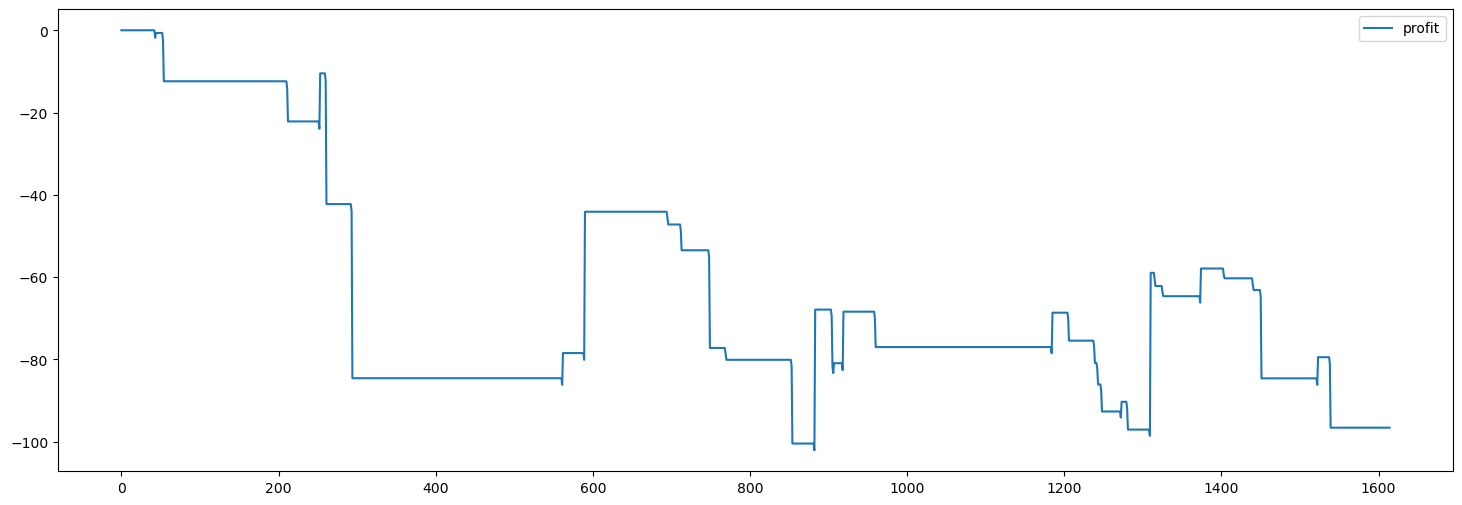

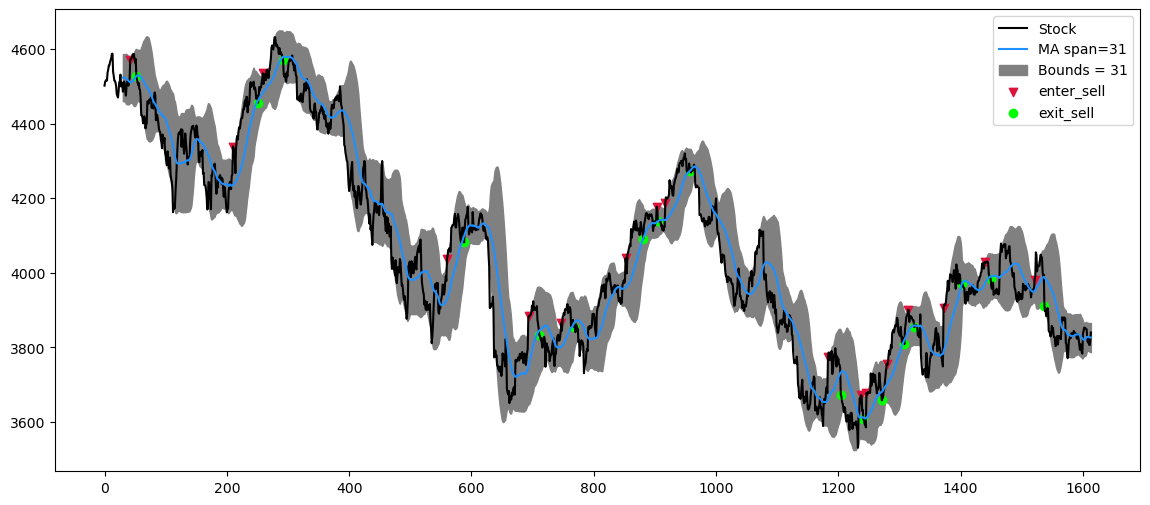

In [8]:
feeds = {
    'SNP500': pd.DataFrame({'Close':df.iloc[train_len:]['SPY Last']}), 
    'VIX' : pd.DataFrame({'Close':df.iloc[train_len:]['VIX Last']})
}

train_data = {
    'SNP500': pd.DataFrame({'Close':df.iloc[:train_len]['SPY Last']}), 
    'VIX' : pd.DataFrame({'Close':df.iloc[:train_len]['VIX Last']})
}


param = {
    'symbol1': 'SNP500',
    'symbol2': 'VIX',
    'train_data': train_data,
    'var_window_interval': 140
}

strategy = MA(**param)
bt = Backtest(feeds, strategy) # commision=0,0004
res, trades = bt.run(plot=True)
print(res)